# Step 3: Build the MLR Model

In [22]:
 # Import Libraries
 # Data and modeling
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from patsy import dmatrix
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import joblib
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import os
os.chdir(r"C:\Users\willi\GitHub\FPM_Assignment_PY\data\processed")
 

Load Data

In [26]:
# Load training data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
hse_price_cleaned = pd.read_csv("hse_price_cleaned.csv")
print("✅ Datasets Loaded Successfully")



✅ Datasets Loaded Successfully


In [40]:

# Fit Linear Regression model
model = smf.ols("price ~ area + distance + schools", data=hse_price_cleaned).fit() 
print(model.summary()) 



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     249.0
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           3.03e-66
Time:                        19:28:45   Log-Likelihood:                -436.96
No. Observations:                 198   AIC:                             881.9
Df Residuals:                     194   BIC:                             895.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.5423      1.744     -5.472      0.0

In [41]:
# Save the fitted model

joblib.dump(model, r"C:\Users\willi\GitHub\FPM_Assignment_PY\models\house_price_model.pkl")

print("✅ Model saved to models/house_price_model.pkl")



✅ Model saved to models/house_price_model.pkl


# Step 4: Check for Multicollinearity using VIF

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Rebuild X matrix from training data (for VIF analysis)
_, X = dmatrices(formula, data=train_data, return_type='dataframe')

# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data


,Variable,VIF
0,Intercept,119.989405
1,area,1.698577
2,distance,1.055206
3,schools,1.764126


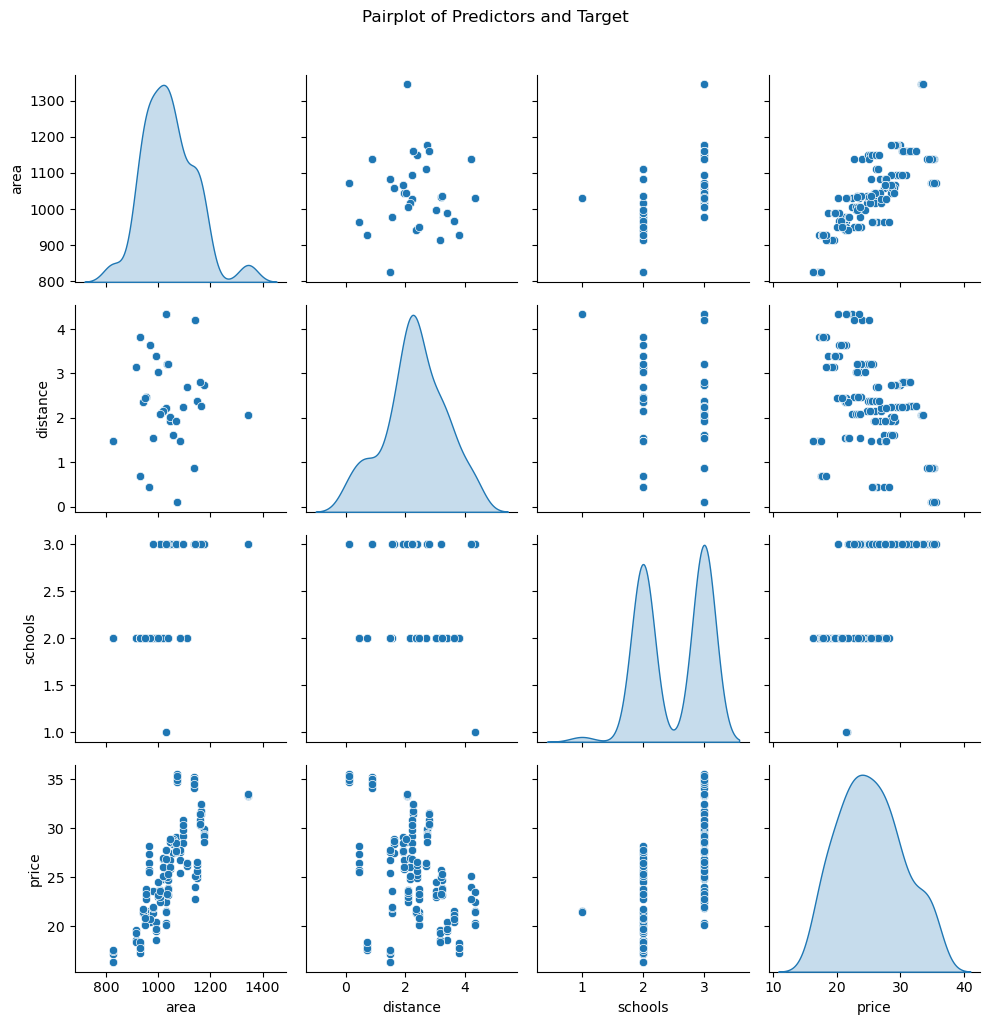

In [43]:
# For Visual insight pair plot of Predictors and Target
sns.pairplot(train_data, diag_kind='kde')
plt.suptitle("Pairplot of Predictors and Target", y=1.02)
plt.tight_layout()
plt.show()

Check for Influential Observations

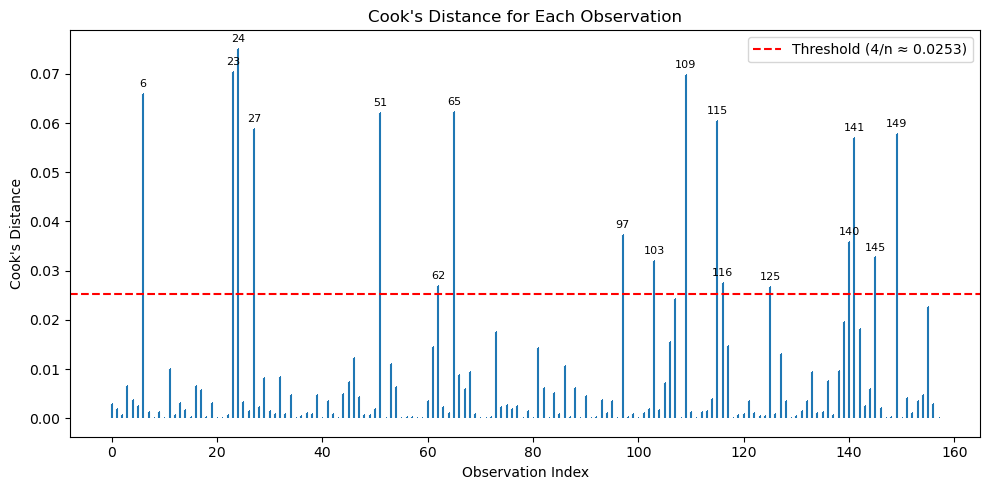

In [17]:
# Influence plot

# Fit your model
X = sm.add_constant(train_data[["area", "distance", "schools"]])
y = train_data["price"]
model = sm.OLS(y, X).fit()

# Calculate Cook's Distance
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

# Threshold for flagging influential points
threshold = 4 / len(train_data)

# Plot Cook's Distance
fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")  # Fixed line
ax.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold (4/n ≈ {threshold:.4f})")
ax.set_title("Cook's Distance for Each Observation")
ax.set_xlabel("Observation Index")
ax.set_ylabel("Cook's Distance")
ax.legend()

# Annotate points above threshold
for i, val in enumerate(cooks_d):
    if val > threshold:
        ax.annotate(f"{i}", (i, val), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

In [34]:
# Highlight Influential Points
influential_points = np.where(cooks_d > 4/len(hse_price_cleaned))[0]
print("Influential points:", influential_points)

Influential points: [  6  23  24  27  51  62  65  97 103 107 109 115 116 125 140 141 145 149
 155]


In [35]:
influential_points_removed = hse_price_cleaned.drop(index=influential_points)
print("✅Influential points removed from the dataset.")

✅Influential points removed from the dataset.


In [44]:
# Rebuild the model without influential points
model_cleaned = smf.ols("price ~ area + distance + schools", data=influential_points_removed).fit()
print(model_cleaned.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     229.4
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           2.17e-60
Time:                        19:29:59   Log-Likelihood:                -391.07
No. Observations:                 179   AIC:                             790.1
Df Residuals:                     175   BIC:                             802.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.7951      1.827     -5.362      0.0

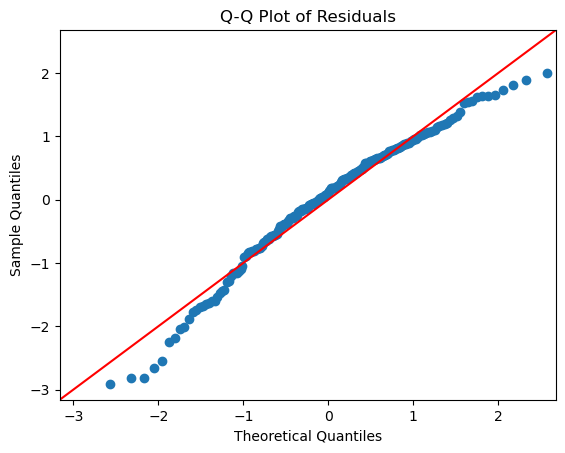

Shapiro-Wilk Test p-value: 0.0004


In [38]:
# Check for normality of residuals
# Q-Q Plot
residuals = model.resid
fig = sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Statistical Test: Shapiro-Wilk Test

shapiro_test = shapiro(residuals)
print("Shapiro-Wilk Test p-value:", round(shapiro_test.pvalue, 4))


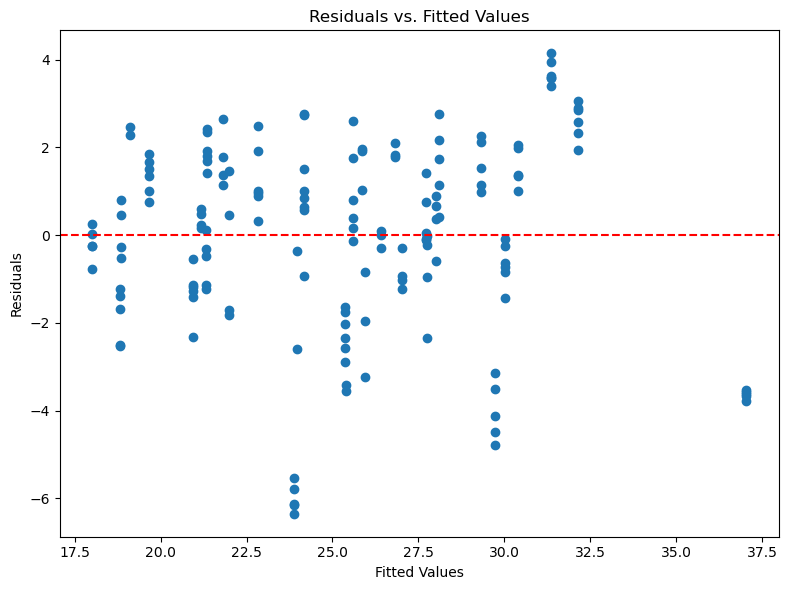

In [ ]:
# Heteroscedasticity (Equal Variance)
# Plot residuals vs. fitted values
fitted_vals = model.fittedvalues

plt.figure(figsize=(8, 6))
plt.scatter(fitted_vals, residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.tight_layout()
plt.show()


# Model Evaluation & RMSE

In [46]:
# Load the test data
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")
print("✅ Test Datasets Loaded Successfully")

✅ Test Datasets Loaded Successfully


Make predictions on the train and test sets

In [47]:
# Predict on training set
y_train_pred = model.predict(X)

# Rebuild X_test matrix

X_test_matrix = dmatrix(formula.replace("price ~", ""), data=X_test, return_type='dataframe')

# Predict on test set
y_test_pred = model.predict(X_test_matrix)


Calculate RMSE



In [48]:
# RMSE on training set
rmse_train = np.sqrt(mean_squared_error(y, y_train_pred))

# RMSE on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("✅ RMSE (Train):", round(rmse_train, 3))
print("✅ RMSE (Test):", round(rmse_test, 3))

✅ RMSE (Train): 2.193
✅ RMSE (Test): 2.222


Final Evaluation

In [49]:
with open(r"C:\Users\willi\GitHub\FPM_Assignment_PY\reports\summary.txt", "w") as f:
    f.write("📊 Model Performance Summary\n")
    f.write(f"Train RMSE: {rmse_train:.3f}\n")
    f.write(f"Test RMSE: {rmse_test:.3f}\n")
    f.write(f"R-squared (Adj): {model.rsquared_adj:.3f}\n")
    f.write("Model complete and ready for deployment.\n")
 